In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import datetime
import os
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib import pyplot
from pylab import rcParams
import pickle as pk
import gc
import requests 
import matplotlib.gridspec as gridspec
import netCDF4 as nc
import hvplot
import hvplot.pandas
import hvplot.xarray
import holoviews as hv
from holoviews import opts

#### Read Downsampled BOTPT Data 

In [2]:
with open('/home/jovyan/data/botpt/2019bottom_pressure15s_F.pkl', 'rb') as E:
    botpt_data = pk.load(E)
df_botptF = pd.DataFrame(botpt_data)
df_botptF['bottom_pressure'] = df_botptF['bottom_pressure'].astype(float)
df_botptF['depth']=df_botptF['bottom_pressure'].astype(float) * 0.670
#MJ03F_cal_depths = [MJ03F_pressure * 0.0670 for MJ03F_pressure in MJ03F_pressure]
#list comprehention
epoch= [i.timestamp() for i in df_botptF.index.to_pydatetime()]
df_botptF['epoch'] = epoch
df_botptF= df_botptF.sort_index()
df_botptF.tail()

,bottom_pressure,depth,epoch
2019-06-27 23:58:45,2254.126709,1510.264895,1.561680e+09
2019-06-27 23:59:00,2254.128906,1510.266367,1.561680e+09
2019-06-27 23:59:15,2254.131104,1510.267839,1.561680e+09
2019-06-27 23:59:30,2254.132080,1510.268494,1.561680e+09
2019-06-27 23:59:45,2254.133057,1510.269148,1.561680e+09


In [3]:
with open('/home/jovyan/data/botpt/2019bottom_pressure15s_E.pkl', 'rb') as E:
    botpt_data = pk.load(E)
df_botptE = pd.DataFrame(botpt_data)
df_botptE['bottom_pressure'] = df_botptE['bottom_pressure'].astype(float)
df_botptE['depth']=df_botptE['bottom_pressure'].astype(float) * 0.670
#MJ03F_cal_depths = [MJ03F_pressure * 0.0670 for MJ03F_pressure in MJ03F_pressure]
#list comprehention
epoch= [i.timestamp() for i in df_botptE.index.to_pydatetime()]
df_botptE['epoch'] = epoch
df_botptE= df_botptE.sort_index()
df_botptE.tail()

,bottom_pressure,depth,epoch
2019-06-27 23:58:45,2241.032715,1501.491919,1.561680e+09
2019-06-27 23:59:00,2241.036133,1501.494209,1.561680e+09
2019-06-27 23:59:15,2241.037354,1501.495027,1.561680e+09
2019-06-27 23:59:30,2241.038086,1501.495518,1.561680e+09
2019-06-27 23:59:45,2241.040039,1501.496826,1.561680e+09


#### Cleaning up the DataFrame

In [4]:
del df_botptE['epoch']
del df_botptE['bottom_pressure']
del df_botptF['epoch']
del df_botptF['bottom_pressure']

In [5]:
df_botptF.tail()

,depth
2019-06-27 23:58:45,1510.264895
2019-06-27 23:59:00,1510.266367
2019-06-27 23:59:15,1510.267839
2019-06-27 23:59:30,1510.268494
2019-06-27 23:59:45,1510.269148


In [6]:
df_botptE.tail()

,depth
2019-06-27 23:58:45,1501.491919
2019-06-27 23:59:00,1501.494209
2019-06-27 23:59:15,1501.495027
2019-06-27 23:59:30,1501.495518
2019-06-27 23:59:45,1501.496826


#### Merge BOTPT E and BOTPT F 

In [7]:
test = pd.merge(df_botptF, df_botptE,how='outer', indicator=True, left_index=True, right_index=True, suffixes=('_F', '_E'))

In [8]:
df_botptMerge = test[test['_merge'] == 'both']
del df_botptMerge['_merge']

In [9]:
df_botptMerge = df_botptMerge.loc['2017-1-1 00:00:00':'2019-6-27 00:00:00']

In [1]:
df_botptMerge.tail()

NameError: name 'df_botptMerge' is not defined

#### Calculate Depth difference 

In [11]:
depthDiff = df_botptMerge['depth_E'].values - df_botptMerge['depth_F'].values

In [12]:
df_botptMerge['diff'] = depthDiff

#### Create time and height vectors for plotting 

In [13]:
# time = list(df_botptMerge.index.values)
#height = x.tolist()
height = df_botptMerge['diff'].tolist()
time_int = []
time = list(pd.to_datetime(df_botptMerge.index.values))
for i in time:
    i = np.datetime64(i).astype(datetime.datetime)
    time_int.append(dates.date2num(i))

/srv/conda/envs/notebook/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


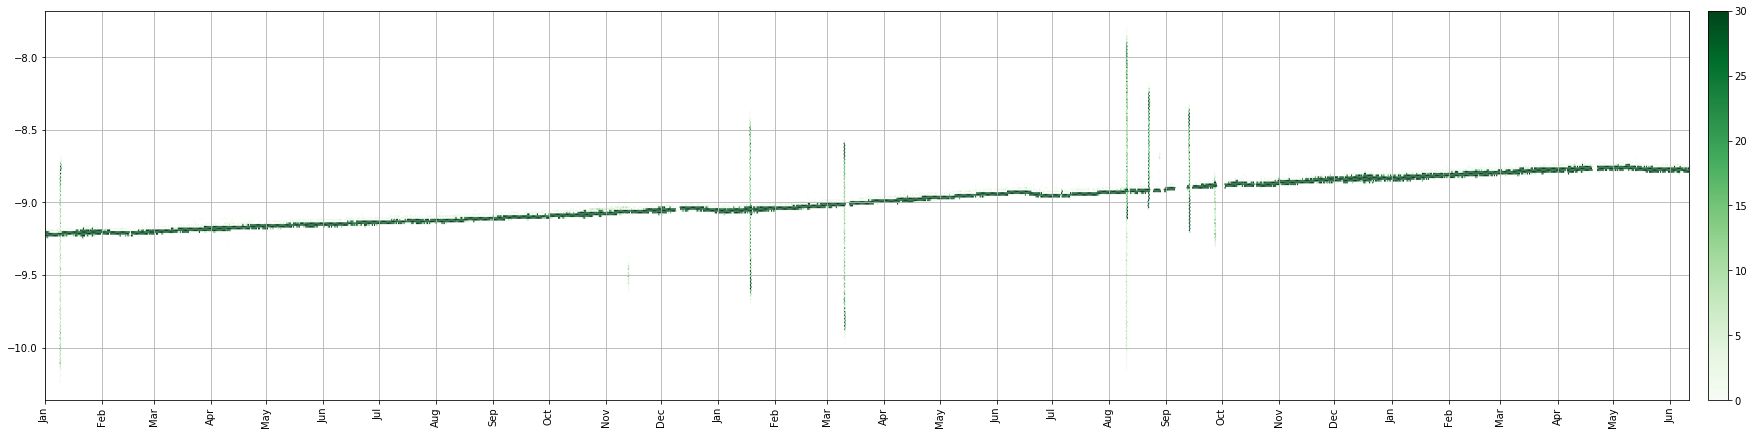

In [14]:
plt.close()
fig, ax = plt.subplots()
fig.set_size_inches(28, 6)
hb1 = ax.hexbin(time_int, height, vmin=0, vmax=30, gridsize=(1500,100), mincnt=1, cmap='Greens', linewidths=0)
fig.colorbar(hb1, pad = 0.01)
ax.yaxis.grid(True)
ax.xaxis.grid(True)
ax.set_xlim(datetime.datetime(2017, 1, 1, 0, 0),datetime.datetime(2019, 6, 11, 0, 0))
years = dates.YearLocator()
months = dates.MonthLocator()
yearsFmt = dates.DateFormatter('\n\n\n%Y')
monthsFmt = dates.DateFormatter('%b')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFmt)
ax.xaxis.set_minor_locator(years)
ax.xaxis.set_minor_formatter(yearsFmt)
plt.tight_layout()
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)
#plt.gca().invert_yaxis()
plt.show()

In [15]:
df_botptMerge['date']=pd.DatetimeIndex(df_botptMerge.index).date
#df_botptMerge.head()

#### Use Groupby to create one day mean measurements

In [16]:
df_botptMean=df_botptMerge.groupby('date').mean()
df_botptMean.tail()

,depth_F,depth_E,diff
date,,,
2019-06-23,1510.389721,1501.617177,-8.772543
2019-06-24,1510.386396,1501.614135,-8.772261
2019-06-25,1510.385356,1501.610929,-8.774428
2019-06-26,1510.392088,1501.618100,-8.773988
2019-06-27,1510.402788,1501.629158,-8.773630


#### Create time and height vectors for plotting 

In [17]:
# time = list(df_botptMerge.index.values)
#height = x.tolist()
height = df_botptMean['diff'].tolist()
time_int = []
time = list(pd.to_datetime(df_botptMean.index.values))
for i in time:
    i = np.datetime64(i).astype(datetime.datetime)
    time_int.append(dates.date2num(i))

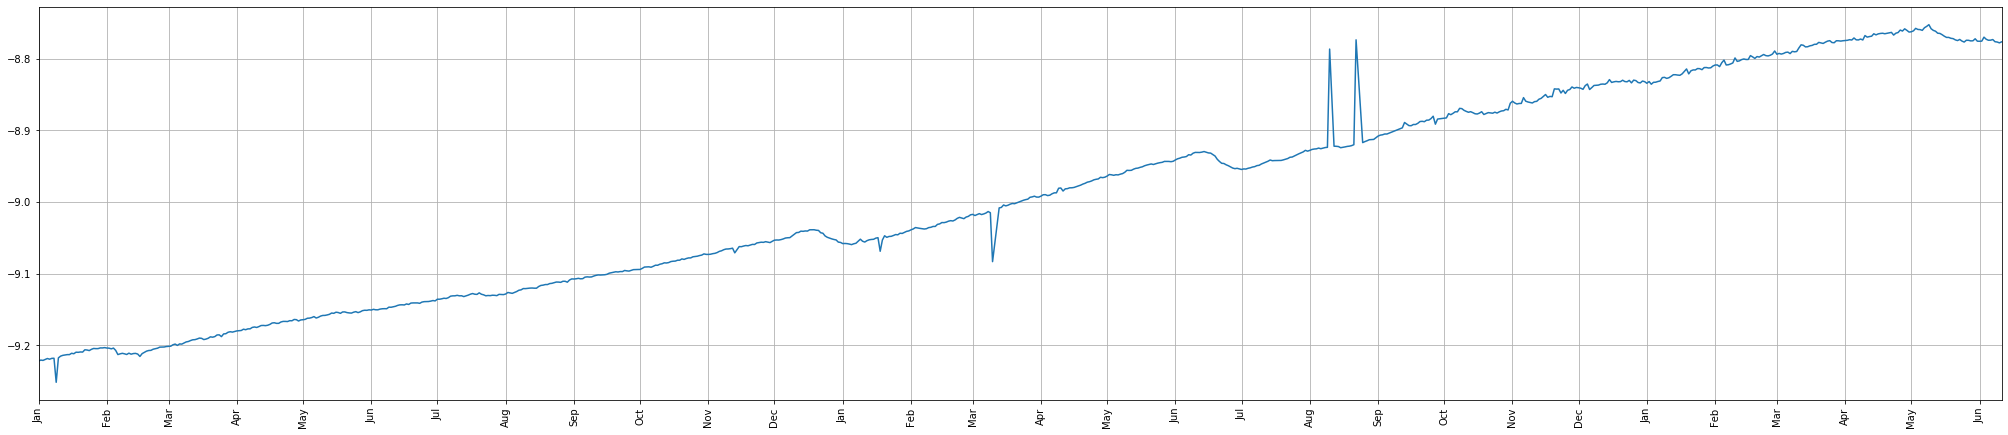

In [18]:
# Plot one day 
plt.close()
fig, ax = plt.subplots()
fig.set_size_inches(28, 6)
hb1 = ax.plot(time_int, height)
ax.yaxis.grid(True)
ax.xaxis.grid(True)
ax.set_xlim(datetime.datetime(2017, 1, 1, 0, 0),datetime.datetime(2019, 6, 11, 0, 0))
years = dates.YearLocator()
months = dates.MonthLocator()
yearsFmt = dates.DateFormatter('\n\n\n%Y')
monthsFmt = dates.DateFormatter('%b')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFmt)
ax.xaxis.set_minor_locator(years)
ax.xaxis.set_minor_formatter(yearsFmt)
plt.tight_layout()
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)
#plt.gca().invert_yaxis()
plt.show()

In [19]:
# Remove spikes
weird_data = np.array(height)
time_array = np.array(time)

cleaner_data = []
cleaner_time = []

# i = 0
# while i < len(weird_data):
#     if (weird_data[i] - weird_data[i-1] > 2

length = len(weird_data)

i = 0
while i < length:
    j = i+2
    while j < length:
        if np.abs(weird_data[i] - weird_data[j]) < .05:
            cleaner_data.append(weird_data[j])
            cleaner_time.append(time_array[j])
            break
        else:
            j += 1
    i = j


### Comparison between plots with and without spikes. 

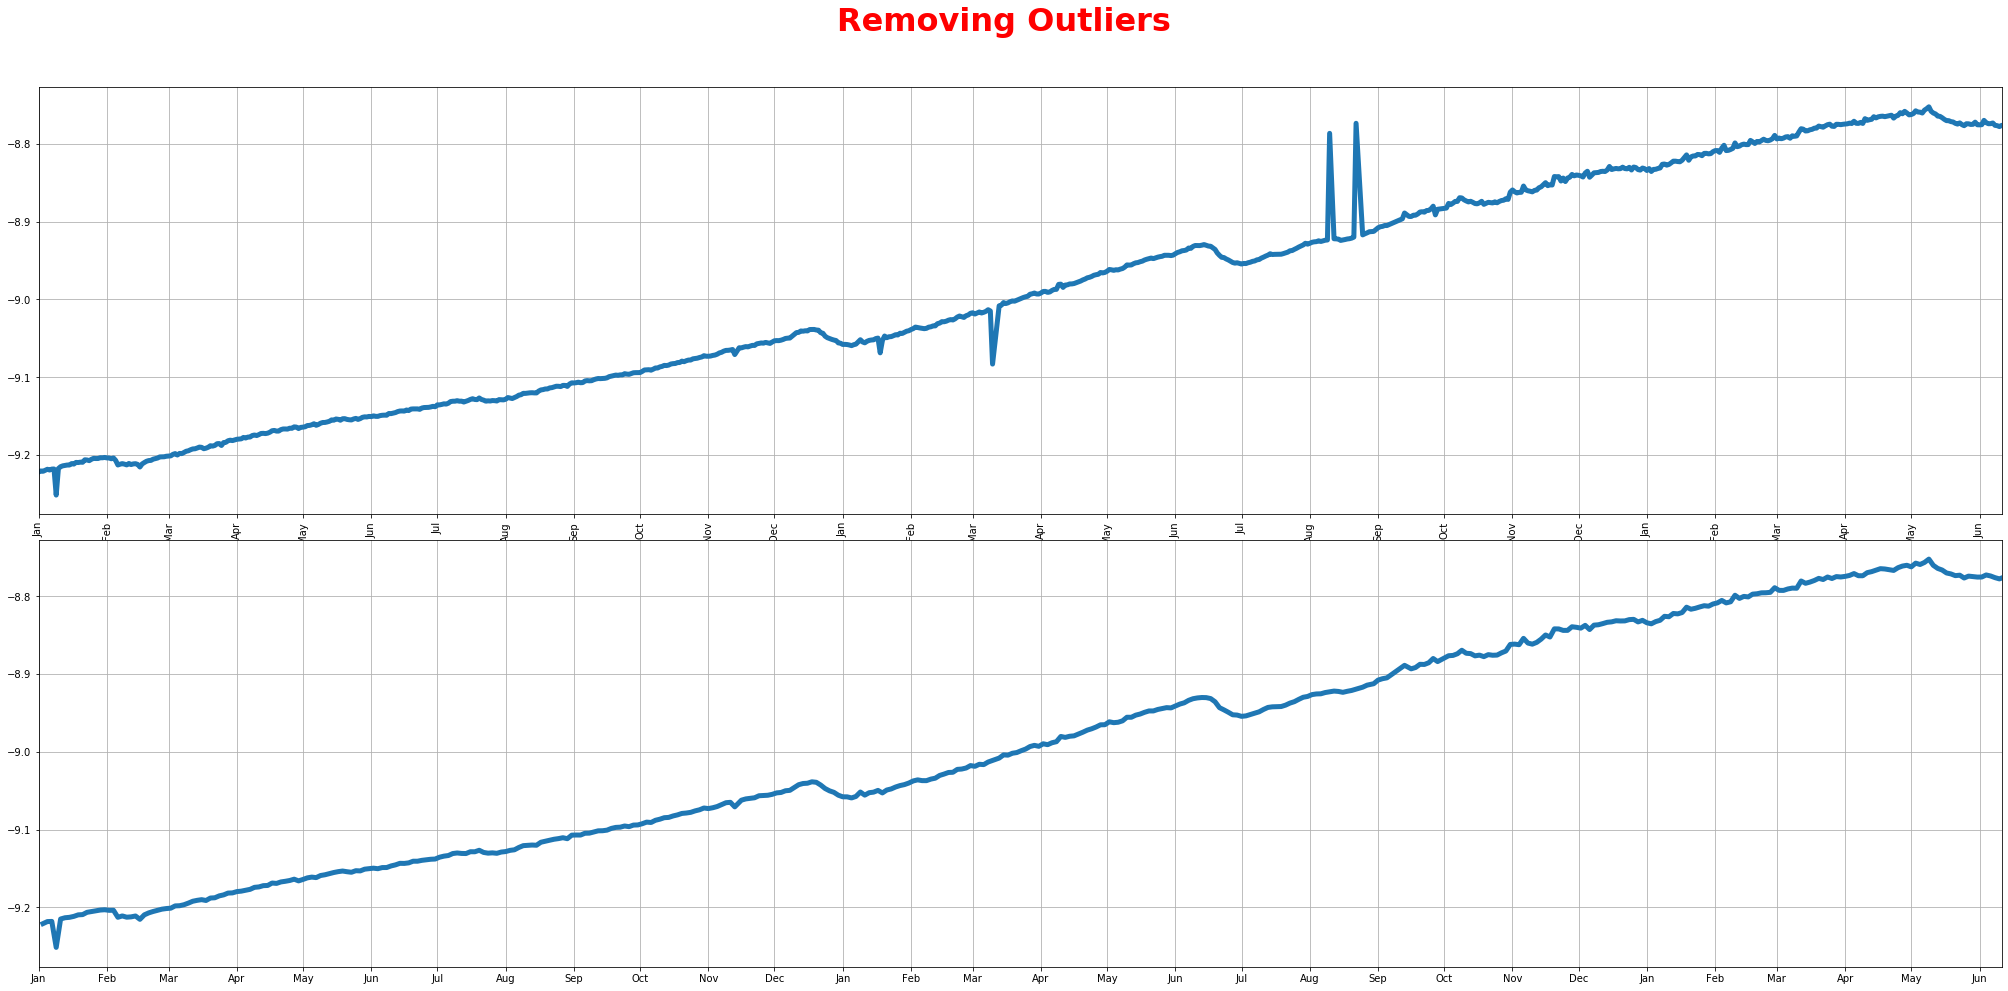

In [20]:
plt.close()
fig3, (ax1,ax2) = plt.subplots(2,1)
fig3.set_size_inches(28, 14)
hb1 = ax1.plot(time_int, height, linewidth=5)
ax1.yaxis.grid(True)
ax1.xaxis.grid(True)
ax1.set_xlim(datetime.datetime(2017, 1, 1, 0, 0),datetime.datetime(2019, 6, 11, 0, 0))
years = dates.YearLocator()
months = dates.MonthLocator()
yearsFmt = dates.DateFormatter('\n\n\n%Y')
monthsFmt = dates.DateFormatter('%b')
ax1.xaxis.set_major_locator(months)
ax1.xaxis.set_major_formatter(monthsFmt)
ax1.xaxis.set_minor_locator(years)
ax1.xaxis.set_minor_formatter(yearsFmt)

hb1 = ax2.plot(cleaner_time, cleaner_data, linewidth=5)
ax2.yaxis.grid(True)
ax2.xaxis.grid(True)
ax2.set_xlim(datetime.datetime(2017, 1, 1, 0, 0),datetime.datetime(2019, 6, 11, 0, 0))
years = dates.YearLocator()
months = dates.MonthLocator()
yearsFmt = dates.DateFormatter('\n\n\n%Y')
monthsFmt = dates.DateFormatter('%b')
ax2.xaxis.set_major_locator(months)
ax2.xaxis.set_major_formatter(monthsFmt)
ax2.xaxis.set_minor_locator(years)
ax2.xaxis.set_minor_formatter(yearsFmt)

plt.tight_layout()
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=90)
plt.suptitle('Removing Outliers', fontsize=32, color= 'red', fontweight = 'bold')
plt.subplots_adjust(top=0.90)
#plt.gca().invert_yaxis()
plt.savefig('/home/jovyan/botpt/figures/botptspikes.png')
plt.show()

#### Import Seismic Data 

In [21]:
seismic_file = '/home/jovyan/data/hypo71.dat.txt'
df_seismic_data = pd.read_csv(seismic_file, delim_whitespace=True, dtype=object)
df_seismic_data['datetime'] = df_seismic_data['yyyymmdd'] + 'T' + \
            df_seismic_data['HHMM'].str.slice(start=0, stop=2) + ':' + \
            df_seismic_data['HHMM'].str.slice(start=2) 
df_seismic_data.index = pd.to_datetime(df_seismic_data['datetime'].values)
df_seismic_data['datetime'] = pd.to_datetime(df_seismic_data['datetime'].values)
df_seismic_data = df_seismic_data.loc['2017-01-1 00:00:00':'2019-06-17 00:00:00']
df_seismic_data.head()
# del df_seismic_data['yyyymmdd']
# del df_seismic_data['HHMM']
del df_seismic_data['Lon(D']
# del df_seismic_data['SSS.SS']
# del df_seismic_data['Depth']
del df_seismic_data['M)']
del df_seismic_data['M).1']
del df_seismic_data['NWR']
del df_seismic_data['GAP']
del df_seismic_data['DMIN']
del df_seismic_data['ERH']
del df_seismic_data['ERZ']
del df_seismic_data['ID']
del df_seismic_data['Lat(D']
del df_seismic_data['PMom']
del df_seismic_data['SMom']
df_seismic_data['Depth'] = df_seismic_data['Depth'].astype('float64').values
df_seismic_data['MW'] = df_seismic_data['MW'].astype('float64').values
df_seismic_data['RMS'] = df_seismic_data['RMS'].astype('float64').values

In [22]:
df_seismic_data.datetime.astype(np.int64).values/1e64
df_seismic_data['date'] =pd.DatetimeIndex(df_seismic_data.datetime).date
df_seismic_data.tail()

,yyyymmdd,HHMM,SSS.SS,Depth,MW,RMS,datetime,date
2019-06-13 22:51:00,20190613,2251,38.04,1.58,0.65,0.02,2019-06-13 22:51:00,2019-06-13
2019-06-14 08:06:00,20190614,0806,0.73,0.61,0.34,0.04,2019-06-14 08:06:00,2019-06-14
2019-06-14 14:34:00,20190614,1434,18.36,0.70,0.25,0.01,2019-06-14 14:34:00,2019-06-14
2019-06-14 22:26:00,20190614,2226,27.48,0.83,0.34,0.01,2019-06-14 22:26:00,2019-06-14
2019-06-16 16:45:00,20190616,1645,2.57,1.48,0.62,0.04,2019-06-16 16:45:00,2019-06-16


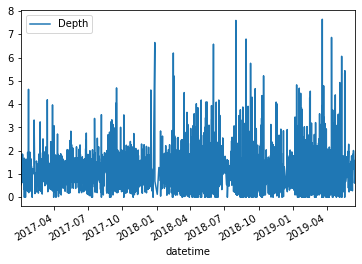

In [23]:
df_seismic_data.plot(x='datetime', y= 'Depth')
plt.savefig('/home/jovyan/botpt/figures/depth.png')

In [24]:
df_eqMean=df_seismic_data.groupby('date').mean()
df_eqCount= df_seismic_data.groupby('date').count()
#del df_eqMean['datetime']
#df_eqMean.columns.name = df_eqMean.index.name
#df_eqMean.index.name = None
df_eqMean.tail()

,Depth,MW,RMS
date,,,
2019-06-11,1.667500,0.53,0.0225
2019-06-12,1.200000,0.63,0.0200
2019-06-13,1.580000,0.65,0.0200
2019-06-14,0.713333,0.31,0.0200
2019-06-16,1.480000,0.62,0.0400


#### Create time and count vectors earthquake frequency vectors for plotting 

In [25]:
depth = df_eqMean['Depth'].tolist()
time_int = []
time = list(pd.to_datetime(df_eqMean.index.values))
for i in time:
    i = np.datetime64(i).astype(datetime.datetime)
    time_int.append(dates.date2num(i))

In [26]:
def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

In [27]:
# smooth data using rolling window that chops off 95th percentile 
depth_av = list(movingaverage(df_eqMean['Depth'],21))

In [28]:
# depth

### Plotting BOTPT caldera inflation vs earthquake count 

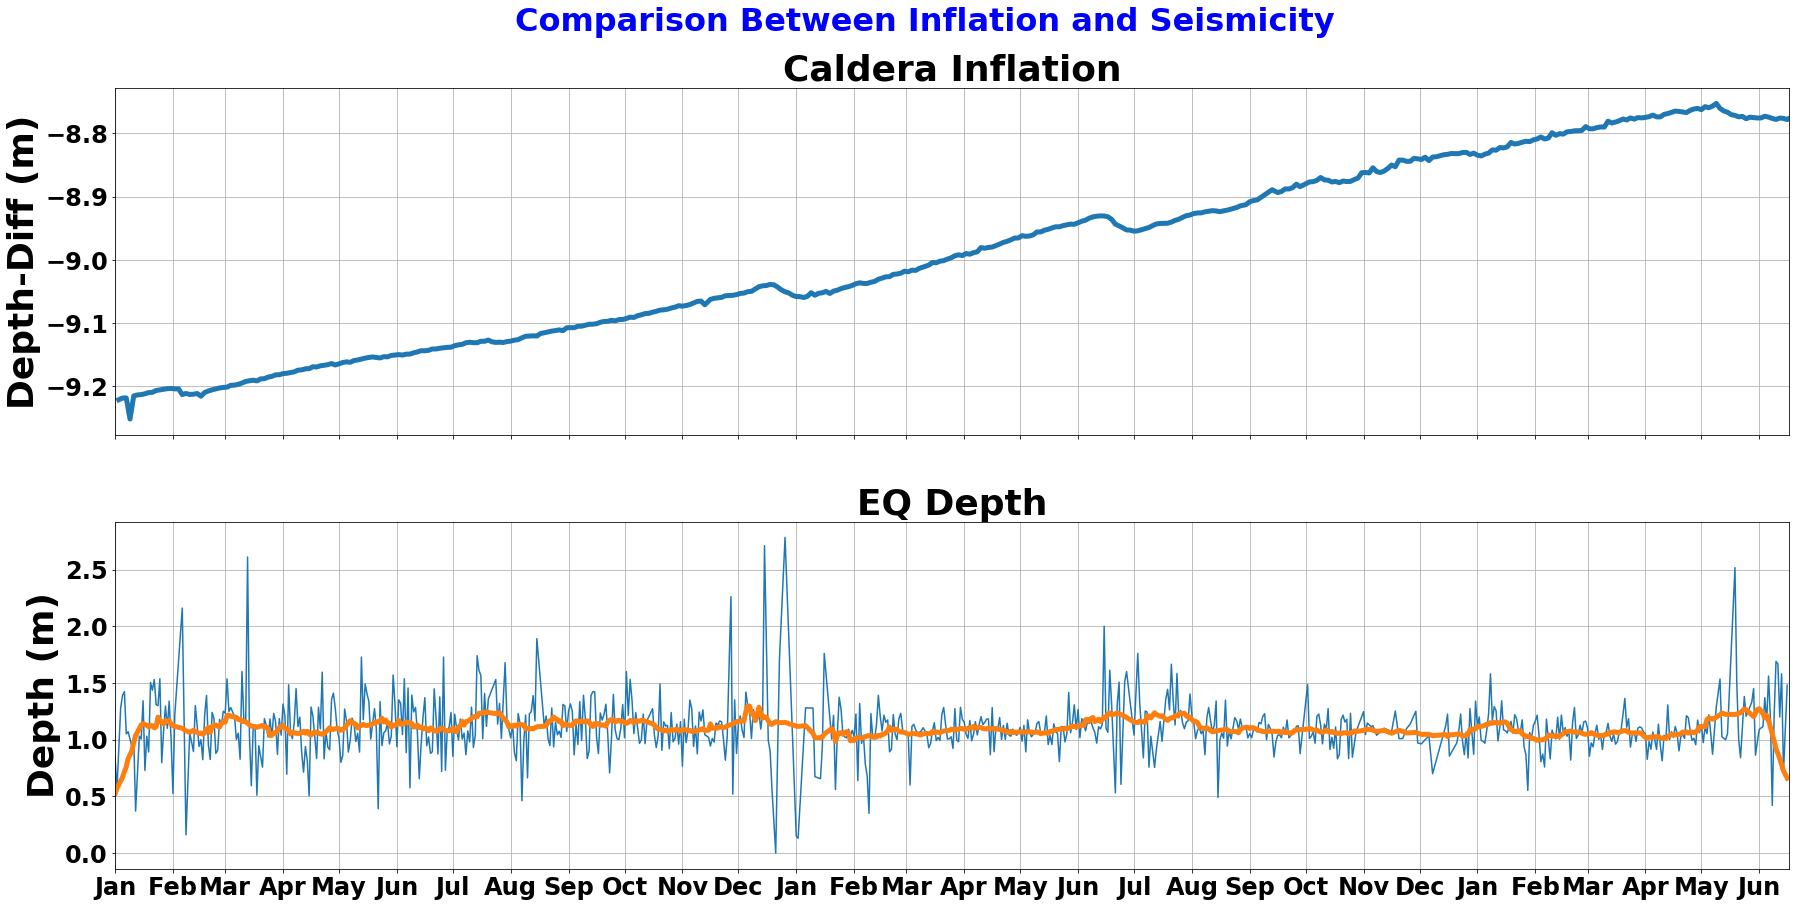

In [29]:
plt.close()
fig4, (ax1,ax2) = plt.subplots(2,1)
fig4.set_size_inches(30, 14)
hb1 = ax1.plot(cleaner_time, cleaner_data, linewidth=5)
ax1.yaxis.grid(True)
ax1.xaxis.grid(True)
ax1.set_xlim(datetime.datetime(2017, 1, 1, 0, 0),datetime.datetime(2019, 6, 17, 0, 0))
#years = dates.YearLocator()
months = dates.MonthLocator()
#yearsFmt = dates.DateFormatter('\n\n\n%Y')
monthsFmt = dates.DateFormatter('%b')
ax1.xaxis.set_major_locator(months)
ax1.xaxis.set_major_formatter(monthsFmt)
#ax1.xaxis.set_minor_locator(years)
#ax1.xaxis.set_minor_formatter(yearsFmt)
ax1.set_title('Caldera Inflation', fontsize=36, fontweight = 'bold')
ax1.set_ylabel('Depth-Diff (m)', fontsize=36, fontweight = 'bold', rotation=90)


hb1 = ax2.plot(time, depth)
hb2 = ax2.plot(time, depth_av, linewidth=5)
ax2.yaxis.grid(True)
ax2.xaxis.grid(True)
ax2.set_xlim(datetime.datetime(2017, 1, 1, 0, 0),datetime.datetime(2019, 6, 17, 0, 0))
years = dates.YearLocator()
months = dates.MonthLocator()
yearsFmt = dates.DateFormatter('\n\n\n%Y')
monthsFmt = dates.DateFormatter('%b')
ax2.xaxis.set_major_locator(months)
ax2.xaxis.set_major_formatter(monthsFmt)
ax2.xaxis.set_minor_locator(years)
ax2.xaxis.set_minor_formatter(yearsFmt)
ax2.set_title('EQ Depth', fontsize=36, fontweight = 'bold')
ax2.set_ylabel('Depth (m)', fontsize=36, fontweight = 'bold', rotation=90)

#plt.tight_layout()
plt.setp(ax1.set_xticklabels([]))
#plt.setp(ax1.xaxis.get_majorticklabels(), rotation=0, fontsize=24)
#plt.setp(ax1.xaxis.get_minorticklabels(), rotation=0, fontsize=24)
plt.setp(ax1.yaxis.get_majorticklabels(), rotation=0, fontsize=24, fontweight = 'bold')

plt.setp(ax2.xaxis.get_majorticklabels(), rotation=0, fontsize=24, fontweight = 'bold')
plt.setp(ax2.xaxis.get_minorticklabels(), rotation=0, fontsize=36, fontweight = 'bold')
plt.setp(ax2.yaxis.get_majorticklabels(), rotation=0, fontsize=24, fontweight = 'bold')

plt.suptitle('Comparison Between Inflation and Seismicity',
            fontsize=32, color= 'blue', fontweight = 'bold')
plt.subplots_adjust(top=0.90, hspace=0.25)
plt.savefig('/home/jovyan/botpt/figures/botptvseqdepth.png')

In [30]:
df_eqMean['MW'].tail(10)

date
2019-06-06    0.833333
2019-06-07    0.603333
2019-06-08    0.855000
2019-06-09    0.625000
2019-06-10    0.510000
2019-06-11    0.530000
2019-06-12    0.630000
2019-06-13    0.650000
2019-06-14    0.310000
2019-06-16    0.620000
Name: MW, dtype: float64

#### Create time and MW vectors for plotting 

In [31]:
MW = df_eqMean['MW'].tolist()
time_int = []
time = list(pd.to_datetime(df_eqMean.index.values))
for i in time:
    i = np.datetime64(i).astype(datetime.datetime)
    time_int.append(dates.date2num(i))

In [32]:
def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

In [33]:
# smooth data using rolling window that chops off 95th percentile 
MW_av = list(movingaverage(df_eqMean['MW'],21))

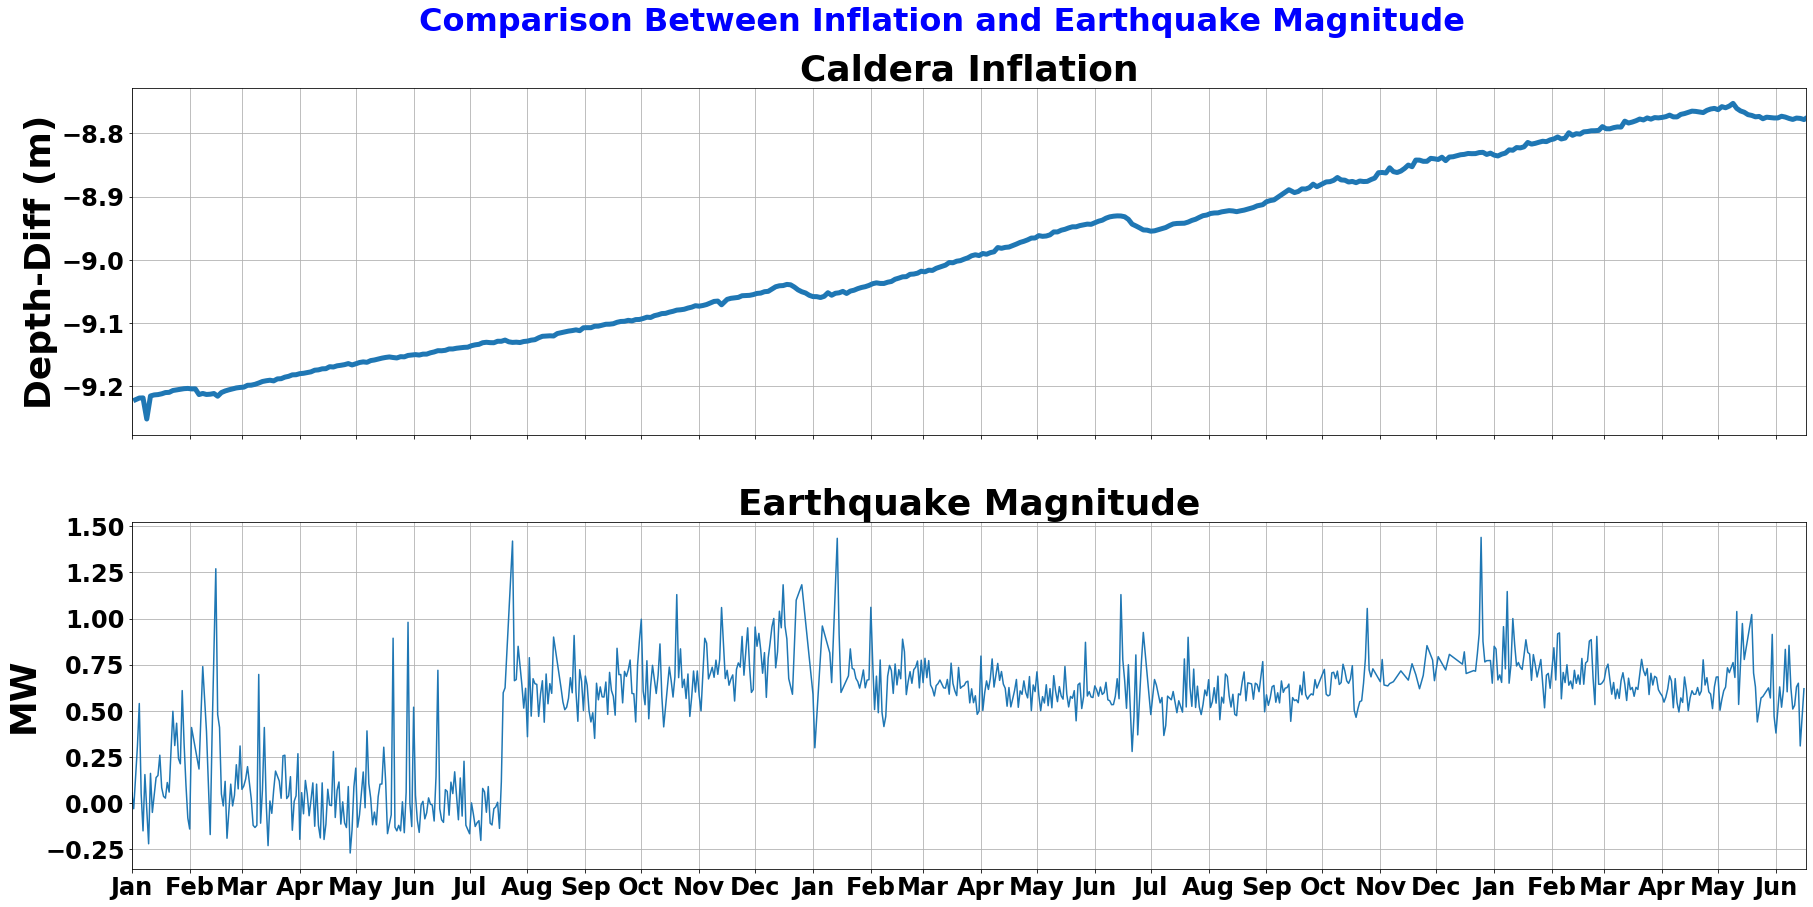

In [34]:
plt.close()
fig4, (ax1,ax3) = plt.subplots(2,1)
fig4.set_size_inches(30, 14)
hb1 = ax1.plot(cleaner_time, cleaner_data, linewidth=5)
ax1.yaxis.grid(True)
ax1.xaxis.grid(True)
ax1.set_xlim(datetime.datetime(2017, 1, 1, 0, 0),datetime.datetime(2019, 6, 17, 0, 0))
#years = dates.YearLocator()
months = dates.MonthLocator()
#yearsFmt = dates.DateFormatter('\n\n\n%Y')
monthsFmt = dates.DateFormatter('%b')
ax1.xaxis.set_major_locator(months)
ax1.xaxis.set_major_formatter(monthsFmt)
#ax1.xaxis.set_minor_locator(years)
#ax1.xaxis.set_minor_formatter(yearsFmt)
ax1.set_title('Caldera Inflation', fontsize=36, fontweight = 'bold')
ax1.set_ylabel('Depth-Diff (m)', fontsize=36, fontweight = 'bold', rotation=90)


hb1 = ax3.plot(time, MW)
# hb2 = ax3.plot(time, MW_av, linewidth=5)
ax3.yaxis.grid(True)
ax3.xaxis.grid(True)
ax3.set_xlim(datetime.datetime(2017, 1, 1, 0, 0),datetime.datetime(2019, 6, 17, 0, 0))
years = dates.YearLocator()
months = dates.MonthLocator()
yearsFmt = dates.DateFormatter('\n\n\n%Y')
monthsFmt = dates.DateFormatter('%b')
ax3.xaxis.set_major_locator(months)
ax3.xaxis.set_major_formatter(monthsFmt)
ax3.xaxis.set_minor_locator(years)
ax3.xaxis.set_minor_formatter(yearsFmt)
ax3.set_title('Earthquake Magnitude', fontsize=36, fontweight = 'bold')
ax3.set_ylabel('MW', fontsize=36, fontweight = 'bold', rotation=90)

#plt.tight_layout()
plt.setp(ax1.set_xticklabels([]))
#plt.setp(ax1.xaxis.get_majorticklabels(), rotation=0, fontsize=24)
#plt.setp(ax1.xaxis.get_minorticklabels(), rotation=0, fontsize=24)
plt.setp(ax1.yaxis.get_majorticklabels(), rotation=0, fontsize=24, fontweight = 'bold')

plt.setp(ax3.xaxis.get_majorticklabels(), rotation=0, fontsize=24, fontweight = 'bold')
plt.setp(ax3.xaxis.get_minorticklabels(), rotation=0, fontsize=36, fontweight = 'bold')
plt.setp(ax3.yaxis.get_majorticklabels(), rotation=0, fontsize=24, fontweight = 'bold')

plt.suptitle('Comparison Between Inflation and Earthquake Magnitude',
            fontsize=32, color= 'blue', fontweight = 'bold')
plt.subplots_adjust(top=0.90, hspace=0.25)
plt.savefig('/home/jovyan/botpt/figures/botptvseqmw.png')

In [35]:
depth = df_eqMean['Depth'].tolist()
time_int = []
time = list(pd.to_datetime(df_eqMean.index.values))
for i in time:
    i = np.datetime64(i).astype(datetime.datetime)
    time_int.append(dates.date2num(i))

In [36]:
def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

In [37]:
# smooth data using rolling window that chops off 95th percentile 
depth_av = list(movingaverage(df_eqMean['Depth'],21))

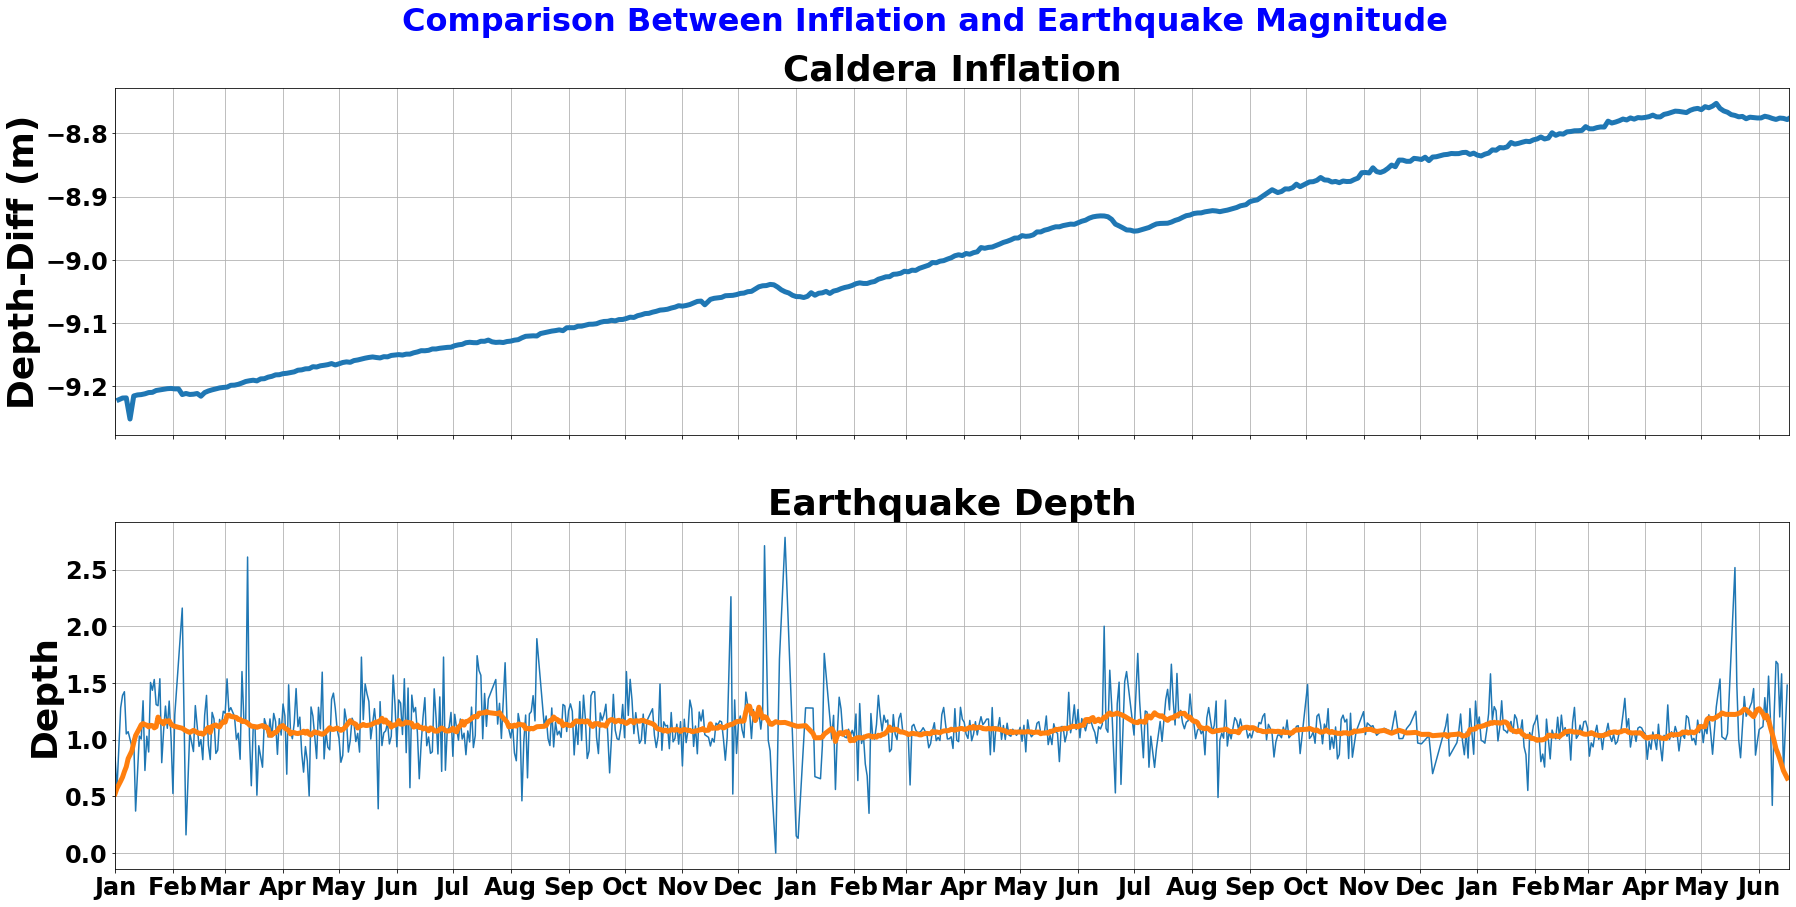

In [38]:
plt.close()
fig4, (ax1,ax4) = plt.subplots(2,1)
fig4.set_size_inches(30, 14)
hb1 = ax1.plot(cleaner_time, cleaner_data, linewidth=5)
ax1.yaxis.grid(True)
ax1.xaxis.grid(True)
ax1.set_xlim(datetime.datetime(2017, 1, 1, 0, 0),datetime.datetime(2019, 6, 17, 0, 0))
#years = dates.YearLocator()
months = dates.MonthLocator()
#yearsFmt = dates.DateFormatter('\n\n\n%Y')
monthsFmt = dates.DateFormatter('%b')
ax1.xaxis.set_major_locator(months)
ax1.xaxis.set_major_formatter(monthsFmt)
#ax1.xaxis.set_minor_locator(years)
#ax1.xaxis.set_minor_formatter(yearsFmt)
ax1.set_title('Caldera Inflation', fontsize=36, fontweight = 'bold')
ax1.set_ylabel('Depth-Diff (m)', fontsize=36, fontweight = 'bold', rotation=90)


hb1 = ax4.plot(time, depth)
hb2 = ax4.plot(time, depth_av, linewidth=5)
ax4.yaxis.grid(True)
ax4.xaxis.grid(True)
ax4.set_xlim(datetime.datetime(2017, 1, 1, 0, 0),datetime.datetime(2019, 6, 17, 0, 0))
years = dates.YearLocator()
months = dates.MonthLocator()
yearsFmt = dates.DateFormatter('\n\n\n%Y')
monthsFmt = dates.DateFormatter('%b')
ax4.xaxis.set_major_locator(months)
ax4.xaxis.set_major_formatter(monthsFmt)
ax4.xaxis.set_minor_locator(years)
ax4.xaxis.set_minor_formatter(yearsFmt)
ax4.set_title('Earthquake Depth', fontsize=36, fontweight = 'bold')
ax4.set_ylabel('Depth', fontsize=36, fontweight = 'bold', rotation=90)

#plt.tight_layout()
plt.setp(ax1.set_xticklabels([]))
#plt.setp(ax1.xaxis.get_majorticklabels(), rotation=0, fontsize=24)
#plt.setp(ax1.xaxis.get_minorticklabels(), rotation=0, fontsize=24)
plt.setp(ax1.yaxis.get_majorticklabels(), rotation=0, fontsize=24, fontweight = 'bold')

plt.setp(ax4.xaxis.get_majorticklabels(), rotation=0, fontsize=24, fontweight = 'bold')
plt.setp(ax4.xaxis.get_minorticklabels(), rotation=0, fontsize=36, fontweight = 'bold')
plt.setp(ax4.yaxis.get_majorticklabels(), rotation=0, fontsize=24, fontweight = 'bold')

plt.suptitle('Comparison Between Inflation and Earthquake Magnitude',
            fontsize=32, color= 'blue', fontweight = 'bold')
plt.subplots_adjust(top=0.90, hspace=0.25)
plt.savefig('/home/jovyan/botpt/figures/botptvseqdepth.png')

NameError: name 'de_av' is not defined

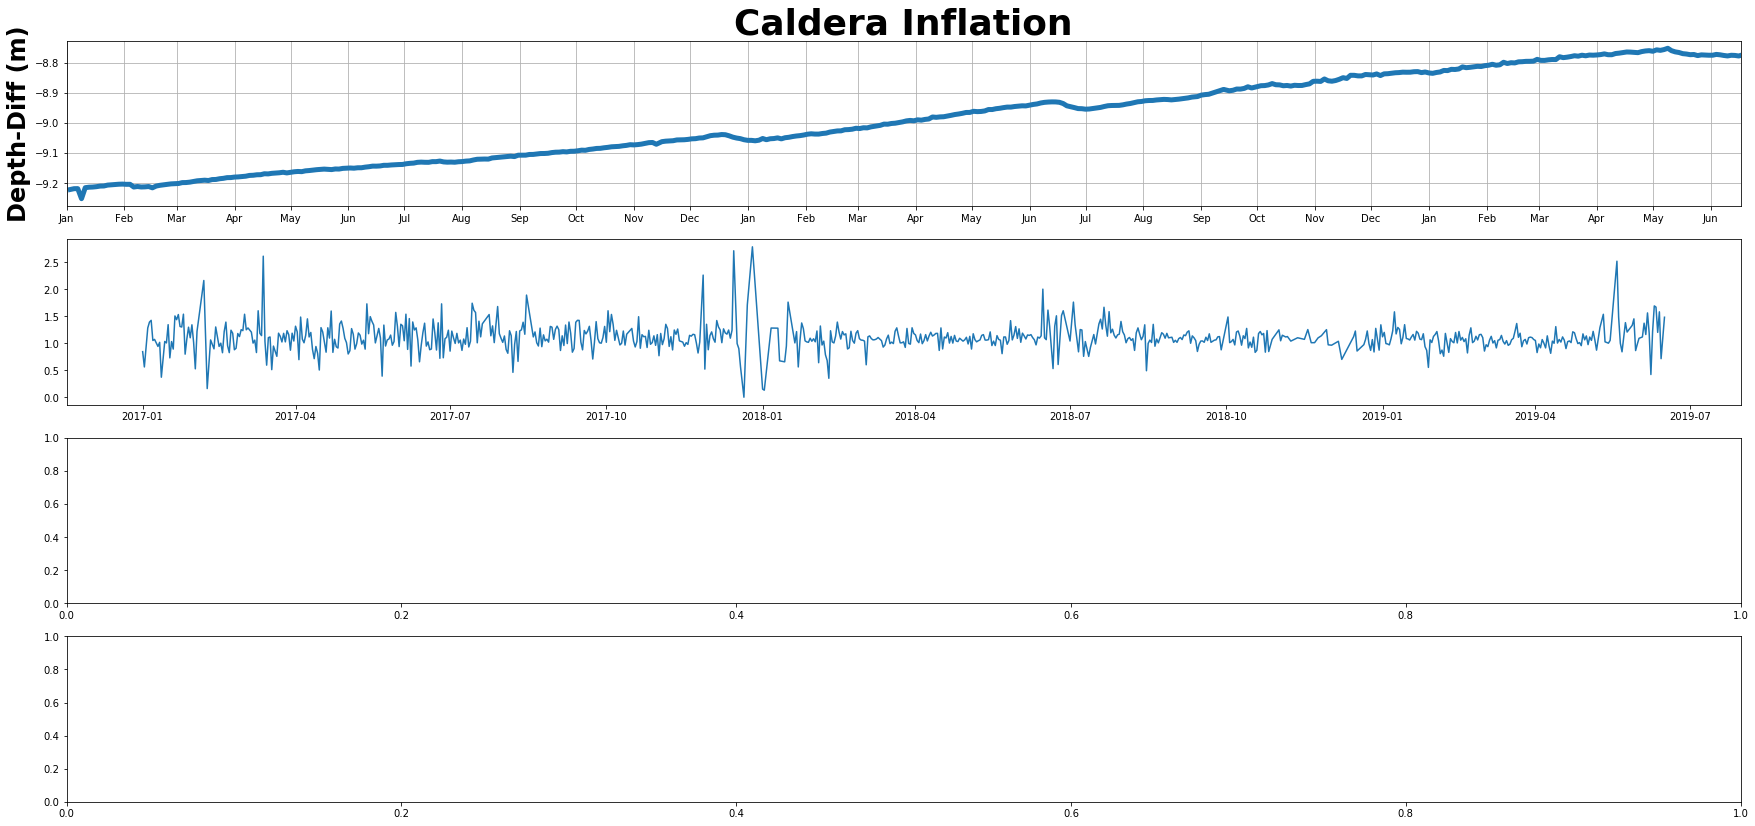

In [39]:
plt.close()
fig4, (ax1,ax2, ax3, ax4) = plt.subplots(4,1)
fig4.set_size_inches(30, 14)
hb1 = ax1.plot(cleaner_time, cleaner_data, linewidth=5)
ax1.yaxis.grid(True)
ax1.xaxis.grid(True)
ax1.set_xlim(datetime.datetime(2017, 1, 1, 0, 0),datetime.datetime(2019, 6, 17, 0, 0))
#years = dates.YearLocator()
months = dates.MonthLocator()
#yearsFmt = dates.DateFormatter('\n\n\n%Y')
monthsFmt = dates.DateFormatter('%b')
ax1.xaxis.set_major_locator(months)
ax1.xaxis.set_major_formatter(monthsFmt)
#ax1.xaxis.set_minor_locator(years)
#ax1.xaxis.set_minor_formatter(yearsFmt)
ax1.set_title('Caldera Inflation', fontsize=36, fontweight = 'bold')
ax1.set_ylabel('Depth-Diff (m)', fontsize=24, fontweight = 'bold', rotation=90)


hb1 = ax2.plot(time, depth)
hb2 = ax2.plot(time, de_av, linewidth=5)
ax2.yaxis.grid(True)
ax2.xaxis.grid(True)
ax2.set_xlim(datetime.datetime(2017, 1, 1, 0, 0),datetime.datetime(2019, 6, 17, 0, 0))
years = dates.YearLocator()
months = dates.MonthLocator()
yearsFmt = dates.DateFormatter('\n\n\n%Y')
monthsFmt = dates.DateFormatter('%b')
ax2.xaxis.set_major_locator(months)
ax2.xaxis.set_major_formatter(monthsFmt)
ax2.xaxis.set_minor_locator(years)
ax2.xaxis.set_minor_formatter(yearsFmt)
ax2.set_title('Earthquake Depth', fontsize=36, fontweight = 'bold')
ax2.set_ylabel('Depth', fontsize=24, fontweight = 'bold', rotation=90)

hb1 = ax3.plot(time, count)
hb2 = ax3.plot(time, count_av, linewidth=5)
ax3.yaxis.grid(True)
ax3.xaxis.grid(True)
ax3.set_xlim(datetime.datetime(2017, 1, 1, 0, 0),datetime.datetime(2019, 6, 17, 0, 0))
years = dates.YearLocator()
months = dates.MonthLocator()
yearsFmt = dates.DateFormatter('\n\n\n%Y')
monthsFmt = dates.DateFormatter('%b')
ax3.xaxis.set_major_locator(months)
ax3.xaxis.set_major_formatter(monthsFmt)
ax3.xaxis.set_minor_locator(years)
ax3.xaxis.set_minor_formatter(yearsFmt)
ax3.set_title('Earthquake Magnitude', fontsize=36, fontweight = 'bold')
ax3.set_ylabel('MW', fontsize=24, fontweight = 'bold', rotation=90)

hb1 = ax4.plot(time, count)
hb2 = ax4.plot(time, count_av, linewidth=5)
ax4.yaxis.grid(True)
ax4.xaxis.grid(True)
ax4.set_xlim(datetime.datetime(2017, 1, 1, 0, 0),datetime.datetime(2019, 6, 17, 0, 0))
years = dates.YearLocator()
months = dates.MonthLocator()
yearsFmt = dates.DateFormatter('\n\n\n%Y')
monthsFmt = dates.DateFormatter('%b')
ax4.xaxis.set_major_locator(months)
ax4.xaxis.set_major_formatter(monthsFmt)
ax4.xaxis.set_minor_locator(years)
ax4.xaxis.set_minor_formatter(yearsFmt)
ax4.set_title('Daily Seismicity', fontsize=36, fontweight = 'bold')
ax4.set_ylabel('EQ/Day', fontsize=24, fontweight = 'bold', rotation=90)

#plt.tight_layout()
plt.setp(ax1.set_xticklabels([]))
#plt.setp(ax1.xaxis.get_majorticklabels(), rotation=0, fontsize=24)
#plt.setp(ax1.xaxis.get_minorticklabels(), rotation=0, fontsize=24)
plt.setp(ax1.yaxis.get_majorticklabels(), rotation=0, fontsize=24, fontweight = 'bold')
plt.setp(ax2.yaxis.get_majorticklabels(), rotation=0, fontsize=24, fontweight = 'bold')
plt.setp(ax3.yaxis.get_majorticklabels(), rotation=0, fontsize=24, fontweight = 'bold')
plt.setp(ax4.yaxis.get_minorticklabels(), rotation=0, fontsize=24, fontweight = 'bold')

# plt.setp(ax4.xaxis.get_majorticklabels(), rotation=0, fontsize=24, fontweight = 'bold')

plt.suptitle('Comparison Between Inflation and Earthquake Magnitude',
            fontsize=32, color= 'blue', fontweight = 'bold')
plt.subplots_adjust(top=0.90, hspace=0.25)
plt.savefig('/home/jovyan/botpt/figures/botptvseq.png')